In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from tqdm.auto import tqdm
from cone.utils.misc import pshape, count_params, randkey
from einops import rearrange
from cone.utils.plot import scatter_movie, imshow_movie
from jax import jacrev, jacfwd, vmap, jit

from diffusers import FlaxAutoencoderKL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

2024-10-25 12:34:55.333622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 12:34:56.178935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 12:34:56.556622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 12:36:19.491256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os

# Set the global TFDS_DATA_DIR environment variable
os.environ['TFDS_DATA_DIR'] = '/scratch/jmb1174/tensorflow_datasets/'

In [4]:
vae, vae_params = FlaxAutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-mse",
    from_pt=True,
    _do_init=True,
    dtype=jnp.bfloat16
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-10-25 12:42:27.443025: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [13]:
dataset = tfds.load('celeb_a_hq/256', split='train', as_supervised=True)

AssertionError: Manual directory /scratch/jmb1174/tensorflow_datasets/downloads/manual does not exist or is empty. Create it and download/extract dataset artifacts in there using instructions:
manual_dir should contain multiple tar files with images (data2x2.tar,
data4x4.tar .. data1024x1024.tar).
Detailed instructions are here:
https://github.com/tkarras/progressive_growing_of_gans#preparing-datasets-for-training

In [6]:


def preprocess(images, target_size=(256, 256)):
    images_resized = []
    for image in images:
        # Convert the NumPy array to a PIL Image
        image = Image.fromarray(image)
        # Resize the image
        image = image.resize(target_size, Image.Resampling.LANCZOS)
        # Convert back to NumPy array and normalize
        image = np.array(image).astype(np.float32) / 255.0
        image = (image - 0.5) * 2.0  # Normalize to [-1, 1]
        images_resized.append(image)
    return jnp.stack(images_resized)

batch_size = 4
images = []
for image, label in tfds.as_numpy(dataset.take(batch_size)):
    images.append(image)
images = preprocess(images)




In [7]:
# from flax.linen.transforms import jit as fjit
from jax import jit


def encode_images(vae, vae_params, images):
    images = images.transpose(0, 3, 1, 2)  # NHWC to NCHW
    latent_outputs = vae.apply({"params": vae_params}, images, method=vae.encode)
    return latent_outputs.latent_dist


def decode_latents(vae, vae_params, latents):
    # Decode the latent representations to get reconstructed images
    reconstructed_images = vae.apply({"params": vae_params}, latents, method=vae.decode)
    return reconstructed_images

# Get latent representations
latent_dist = encode_images(vae, vae_params, images)

# Decode the latents to get reconstructed images
reconstructed_images = decode_latents(vae, vae_params, latent_dist.mean)

reconstructed_images = np.array(reconstructed_images.sample)
reconstructed_images = reconstructed_images.transpose(0, 2, 3, 1)  # NCHW to NHWC

In [8]:
key = randkey()
z_sampled = latent_dist.sample(key)

# z_sampled =  self.mean + self.std * jax.random.normal(key, self.mean.shape)
# Decode the latents to get reconstructed images
reconstructed_images = decode_latents(vae, vae_params, z_sampled)

reconstructed_images = np.array(reconstructed_images.sample)
reconstructed_images = reconstructed_images.transpose(0, 2, 3, 1)  # NCHW to NHWC

In [9]:


# Un-normalize images from [-1, 1] to [0, 1] for visualization
def unnormalize(images):
    images = (images + 1.0) / 2.0  # Scale from [-1, 1] to [0, 1]
    images = np.clip(images, 0.0, 1.0)
    return images

# Un-normalize both original and reconstructed images
images_vis = unnormalize(np.array(images))
reconstructed_images_vis = unnormalize(reconstructed_images)

# Plot the original and reconstructed images
def plot_images(original_images, reconstructed_images):
    num_images = original_images.shape[0]
    plt.figure(figsize=(12, 5))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.axis('off')
        if i == 0:
            
            plt.title('Original Images')

        # Reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed_images[i])
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed Images')
    plt.tight_layout()
    plt.show()

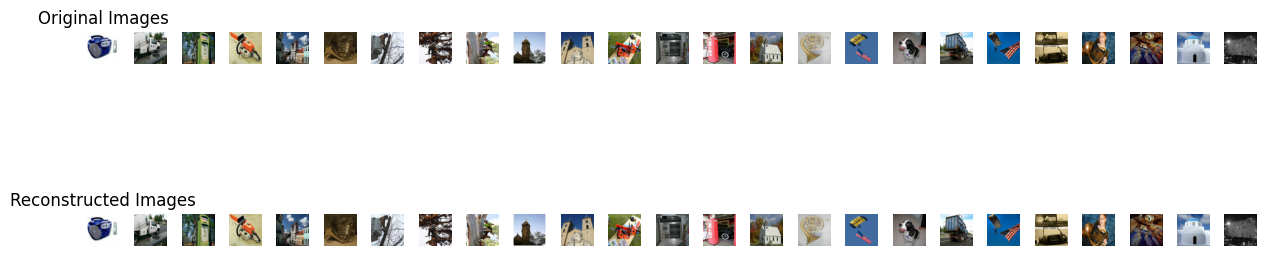

In [10]:
plot_images(images_vis, reconstructed_images_vis)